# Spike Plotting

Brief 1-2 sentence description of notebook.

In [1]:
import glob
import re
import os

In [2]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d


/tmp/ipykernel_3926050/64613958.py:6: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


## Inputs & Data

Explanation of each input and where it comes from.

In [3]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case

TRIAL_LENGTH = 10
SAMPLING_RATE = 20000
TONE_TIMESTAMP_DF = pd.read_excel("../../rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

INPUT_DIR=glob.glob("/scratch/back_up/reward_competition_extention/proc/phy_curation/*")

In [4]:
TRIAL_NUMBER_COL = "trial_number"

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [5]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names

def calc_bmi(weight, height):
    """
    This is a function that calculates BMI.
    it uses height and weight...etc.
    Meghan plz show us your docsctring format here.
    """
    bmi = weight/(height**2)
    return(bmi)


In [6]:
def find_closest(target, reference_list):
    """
    Finds the closest number in a reference list to the given target number.

    Parameters:
    - target (float or int): The number for which we want to find the closest value.
    - reference_list (list of float or int): The list of numbers in which we want to search.

    Returns:
    - float or int: The closest number from the reference list to the target.
    """

    # Using the 'min' function with a custom key to determine the closest value by minimal absolute difference
    closest_value = min(reference_list, key=lambda x: abs(x - target))
    
    return closest_value

In [7]:
def find_index_in_group(group, value_column, new_column_name):
    unique_values = sorted(list(set(group[value_column])))
    group[new_column_name] = group[value_column].apply(lambda x: unique_values.index(x) + 1)
    return group

### Getting the subject IDs from the file name

- Dropping all unlabeled trials

In [8]:
all_trials_df = TONE_TIMESTAMP_DF.dropna(subset="condition").sort_values(by=["recording_file", "time_stamp_index"]).reset_index(drop=True)

- Making sure that all timestamps are integers

In [9]:
all_trials_df["time"] = all_trials_df["time"].astype(int)
all_trials_df["time_stamp_index"] = all_trials_df["time_stamp_index"].astype(int)
all_trials_df["video_frame"] = all_trials_df["video_frame"].astype(int)

In [10]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13
0,6310663,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,NaN,NaN
1,7910662,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,NaN,NaN
2,9710660,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,NaN,NaN
3,11310658,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,NaN,NaN
4,12810657,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,NaN,NaN


- Original timestamps are based on ephys recordings at 20kHz. The LFP will be at 1kHz, so we will need to divide all the timestamps by 20

In [11]:
all_trials_df["resampled_index"] = all_trials_df["time_stamp_index"] // 20

In [12]:
all_trials_df["recording_dir"].unique()

array(['20221202_134600_omission_and_competition_subject_6_1_and_6_2',
       '20221203_154800_omission_and_competition_subject_6_4_and_6_1',
       '20221214_125409_om_and_comp_6_1_and_6_3',
       '20221215_145401_comp_amd_om_6_1_and_6_3',
       '20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2',
       '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2'],
      dtype=object)

- Getting a list of all the subjects through the recording name

In [13]:
all_trials_df["all_subjects"] = all_trials_df["recording_dir"].apply(lambda x: ["{}.{}".format(tup[0],tup[1]) for tup in re.findall(r'(\d+)-(\d+)', x.replace("_", "-"))[1:]])

In [14]:
all_trials_df["all_subjects"].head()

0    [6.1, 6.2]
1    [6.1, 6.2]
2    [6.1, 6.2]
3    [6.1, 6.2]
4    [6.1, 6.2]
Name: all_subjects, dtype: object

- Getting the current subject of the recording through the ending of the recording name file

In [15]:
all_trials_df["subject_info"].head()

0    6_1_top_2_base_3
1    6_1_top_2_base_3
2    6_1_top_2_base_3
3    6_1_top_2_base_3
4    6_1_top_2_base_3
Name: subject_info, dtype: object

In [16]:
all_trials_df["current_subject"] = all_trials_df["subject_info"].apply(lambda x: ".".join(x.replace("-","_").split("_")[:2]))

In [17]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject
0,6310663,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,69541,"[6.1, 6.2]",6.1
1,7910662,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,149541,"[6.1, 6.2]",6.1
2,9710660,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,239541,"[6.1, 6.2]",6.1
3,11310658,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,NaN,NaN,319541,"[6.1, 6.2]",6.1
4,12810657,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,394541,"[6.1, 6.2]",6.1


- Labeling the trial as a winner or loser if the winner matches the subject id or not

In [18]:
all_trials_df["trial_outcome"] = all_trials_df.apply(
    lambda x: "win" if str(x["condition"]).strip() == str(x["current_subject"]) 
             else ("lose" if str(x["condition"]) in x["all_subjects"] 
                   else x["condition"]), axis=1)

In [19]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome
0,6310663,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,69541,"[6.1, 6.2]",6.1,rewarded
1,7910662,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,149541,"[6.1, 6.2]",6.1,rewarded
2,9710660,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,239541,"[6.1, 6.2]",6.1,rewarded
3,11310658,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,NaN,NaN,319541,"[6.1, 6.2]",6.1,omission
4,12810657,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,394541,"[6.1, 6.2]",6.1,rewarded


In [20]:
all_trials_df

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome
0,6310663,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,69541,"[6.1, 6.2]",6.1,rewarded
1,7910662,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,149541,"[6.1, 6.2]",6.1,rewarded
2,9710660,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,239541,"[6.1, 6.2]",6.1,rewarded
3,11310658,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,NaN,NaN,319541,"[6.1, 6.2]",6.1,omission
4,12810657,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,NaN,NaN,394541,"[6.1, 6.2]",6.1,rewarded
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,32281440,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,29088396,20230621_111240_standard_comp_to_omission_D5_s...,29033,2.0,1-4_t3b3L_box1,1.2,Subj 1 then Subj 2,NaN,1454419,"[1.4, 1.2]",1.4,lose
699,34481464,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,31288420,20230621_111240_standard_comp_to_omission_D5_s...,31230,1.0,1-4_t3b3L_box1,1.2,Subj 1 then Subj 2,NaN,1564421,"[1.4, 1.2]",1.4,lose
700,34481464,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,31288420,20230621_111240_standard_comp_to_omission_D5_s...,31230,2.0,1-4_t3b3L_box1,1.2,Subj 1 then Subj 2,NaN,1564421,"[1.4, 1.2]",1.4,lose
701,35681479,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,32488435,20230621_111240_standard_comp_to_omission_D5_s...,32428,1.0,1-4_t3b3L_box1,1.2,Subj 1 then Subj 2,NaN,1624421,"[1.4, 1.2]",1.4,lose


In [21]:
all_trials_df["competition_closeness"] = all_trials_df["competition_closeness"].fillna("")

In [22]:
all_trials_df["competition_closeness"].unique()

array(['', 'Subj 1 Only', 'Subj 2 blocking Subj 1', 'Subj 1 then Subj 2',
       'Subj 1 blocking Subj 2', 'Subj 2 Only', 'Subj 2 then Subj 1',
       'Close Call'], dtype=object)

In [23]:
all_trials_df = all_trials_df[~all_trials_df["competition_closeness"].str.contains("Only")]

# Reading in Phy

- Reading in a spreadsheet of all the unit classifications
    - They are divided up into good units, multi-units, and noise

In [24]:
INPUT_DIR

['/scratch/back_up/reward_competition_extention/proc/phy_curation/tbc',
 '/scratch/back_up/reward_competition_extention/proc/phy_curation/20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged.rec',
 '/scratch/back_up/reward_competition_extention/proc/phy_curation/20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec',
 '/scratch/back_up/reward_competition_extention/proc/phy_curation/20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec',
 '/scratch/back_up/reward_competition_extention/proc/phy_curation/20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.rec']

In [25]:
recording_to_cluster_info = {}
for recording_dir in INPUT_DIR:
    try:
        recording_basename = os.path.basename(recording_dir).strip(".rec")
        file_path = os.path.join(recording_dir, "phy", "cluster_info.tsv")
        recording_to_cluster_info[recording_basename] = pd.read_csv(file_path, sep="\t")
    except Exception as e:
        print(e)

[Errno 2] No such file or directory: '/scratch/back_up/reward_competition_extention/proc/phy_curation/tbc/phy/cluster_info.tsv'


In [26]:
recording_to_cluster_info[list(recording_to_cluster_info.keys())[0]]

,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
0,0,11,2,31,11.722398,0,0,0.0,2.263069,mua,7899,0,1
1,1,4,1,9,11.474627,0,0,0.0,1.634487,mua,5705,0,2
2,2,25,7,60,9.400171,0,0,0.0,7.271388,mua,25380,0,3
3,3,71,22,243,8.729426,1,0,20.0,9.474292,unsorted,33069,0,5
4,4,1,1,8,12.972078,1,0,20.0,1.208747,unsorted,4219,0,6
5,5,4,0,14,9.769127,2,0,40.0,1.879731,unsorted,6561,0,7
6,6,2,0,11,13.532221,2,0,40.0,11.421351,unsorted,39865,0,8
7,7,58,30,99,9.302568,2,0,40.0,20.851808,unsorted,72781,0,9
8,8,29,12,94,7.241092,3,0,60.0,4.613521,unsorted,16103,0,10
9,9,1,0,6,7.570013,4,0,80.0,1.279799,unsorted,4467,0,11


- Combining all the unit info dataframes and adding the recording name

In [27]:
recording_to_cluster_info_df = pd.concat(recording_to_cluster_info, names=['recording_name']).reset_index(level=1, drop=True).reset_index()


In [28]:
recording_to_cluster_info_df.head()

,recording_name,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
0,20230621_111240_standard_comp_to_omission_D5_s...,0,11,2,31,11.722398,0,0.0,0.0,2.263069,mua,7899,0,1.0
1,20230621_111240_standard_comp_to_omission_D5_s...,1,4,1,9,11.474627,0,0.0,0.0,1.634487,mua,5705,0,2.0
2,20230621_111240_standard_comp_to_omission_D5_s...,2,25,7,60,9.400171,0,0.0,0.0,7.271388,mua,25380,0,3.0
3,20230621_111240_standard_comp_to_omission_D5_s...,3,71,22,243,8.729426,1,0.0,20.0,9.474292,unsorted,33069,0,5.0
4,20230621_111240_standard_comp_to_omission_D5_s...,4,1,1,8,12.972078,1,0.0,20.0,1.208747,unsorted,4219,0,6.0


- Filtering for the good units

In [29]:
good_unit_cluster_info_df = recording_to_cluster_info_df[recording_to_cluster_info_df["group"] == "good"].reset_index(drop=True)

In [30]:
good_unit_cluster_info_df.head()

,recording_name,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
0,20230620_114347_standard_comp_to_omission_D4_s...,2,0,0,0,24.692951,1,0.0,20.0,1.070175,good,3658,0,3.0
1,20230620_114347_standard_comp_to_omission_D4_s...,20,0,0,0,19.467382,11,0.0,220.0,0.739585,good,2528,0,7.0
2,20230620_114347_standard_comp_to_omission_D4_s...,22,0,0,0,21.967876,13,0.0,260.0,0.465459,good,1591,0,8.0
3,20230620_114347_standard_comp_to_omission_D4_s...,34,0,0,0,23.960157,22,0.0,440.0,0.402266,good,1375,0,17.0
4,20230620_114347_standard_comp_to_omission_D4_s...,57,2,0,7,22.906088,0,NaN,0.0,2.406577,good,8226,0,NaN


In [31]:
recording_to_good_unit_ids = good_unit_cluster_info_df.groupby('recording_name')['cluster_id'].apply(list).to_dict()


- A list of all the unit IDs that each spike came from in order
    - First item is first spike, second item is second spike, etc.

In [32]:
recording_to_spike_clusters = {}
for recording_dir in INPUT_DIR:
    try:
        recording_basename = os.path.basename(recording_dir).strip(".rec")
        file_path = os.path.join(recording_dir, "phy", "spike_clusters.npy")
        recording_to_spike_clusters[recording_basename] = np.load(file_path)
    except Exception as e:
        print(e)

[Errno 2] No such file or directory: '/scratch/back_up/reward_competition_extention/proc/phy_curation/tbc/phy/spike_clusters.npy'


In [33]:
recording_to_spike_clusters[list(recording_to_spike_clusters.keys())[0]]

array([36, 17, 36, ..., 36, 48, 53], dtype=int32)

In [34]:
recording_to_spike_clusters[list(recording_to_spike_clusters.keys())[0]].shape

(883920,)

- The times that all the spikes happened

In [35]:
recording_to_spike_times = {}
for recording_dir in INPUT_DIR:
    try:
        recording_basename = os.path.basename(recording_dir).strip(".rec")
        file_path = os.path.join(recording_dir, "phy", "spike_times.npy")
        recording_to_spike_times[recording_basename] = np.load(file_path)
    except Exception as e:
        print(e)

[Errno 2] No such file or directory: '/scratch/back_up/reward_competition_extention/proc/phy_curation/tbc/phy/spike_times.npy'


In [36]:
recording_to_spike_times[list(recording_to_spike_times.keys())[0]]

array([[      63],
       [     446],
       [     476],
       ...,
       [69807491],
       [69807703],
       [69807787]])

In [37]:
recording_to_spike_times[list(recording_to_spike_times.keys())[0]].shape

(883920, 1)

### Combining everything into a dataframe

In [38]:
recording_to_spike_df = {}
for recording_dir in INPUT_DIR:
    try:
        recording_basename = os.path.basename(recording_dir).strip(".rec")
        cluster_info_path = os.path.join(recording_dir, "phy", "cluster_info.tsv")
        cluster_info_df = pd.read_csv(cluster_info_path, sep="\t")

        spike_clusters_path = os.path.join(recording_dir, "phy", "spike_clusters.npy")
        spike_clusters = np.load(spike_clusters_path)
        
        spike_times_path = os.path.join(recording_dir, "phy", "spike_times.npy")
        spike_times = np.load(spike_times_path)

        spike_df = pd.DataFrame({'spike_clusters': spike_clusters, 'spike_times': spike_times.T[0]})

        merged_df = spike_df.merge(cluster_info_df, left_on='spike_clusters', right_on='cluster_id', how="left")
        merged_df["recording_name"] = recording_basename

        merged_df["timestamp_isi"] = merged_df.groupby('spike_clusters')["spike_times"].diff()
        merged_df["current_isi"] = merged_df["timestamp_isi"] / SAMPLING_RATE
        
        if not merged_df.empty:
            recording_to_spike_df[recording_basename] = merged_df
       
    except Exception as e:
        print(e)

[Errno 2] No such file or directory: '/scratch/back_up/reward_competition_extention/proc/phy_curation/tbc/phy/cluster_info.tsv'


- Combining the spike time df for all recordings

In [39]:
all_spike_time_df = pd.concat(recording_to_spike_df.values())

In [40]:
all_spike_time_df = all_spike_time_df[all_spike_time_df["group"] == "good"].reset_index(drop=True)

In [41]:
all_spike_time_df.head()

,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id,recording_name,timestamp_isi,current_isi
0,89,535,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,NaN,NaN
1,89,1047,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,512.0,0.02560
2,89,1384,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,337.0,0.01685
3,89,1585,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,201.0,0.01005
4,89,1793,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,208.0,0.01040


In [42]:
all_spike_time_df.tail()

,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id,recording_name,timestamp_isi,current_isi
622770,146,38957244,146,0,0,0,14.943707,6,0.0,120.0,0.695852,good,1433,0,18.0,20230619_115321_standard_comp_to_omission_D3_s...,173.0,0.00865
622771,146,38957331,146,0,0,0,14.943707,6,0.0,120.0,0.695852,good,1433,0,18.0,20230619_115321_standard_comp_to_omission_D3_s...,87.0,0.00435
622772,204,38957511,204,1,0,1,11.366614,6,0.0,120.0,8.020020,good,16516,0,17.0,20230619_115321_standard_comp_to_omission_D3_s...,3072.0,0.15360
622773,44,38957537,44,3,1,29,9.739503,17,0.0,340.0,13.732511,good,28280,0,46.0,20230619_115321_standard_comp_to_omission_D3_s...,2342.0,0.11710
622774,134,38957868,134,5,4,17,8.562255,2,0.0,40.0,14.537135,good,29937,0,11.0,20230619_115321_standard_comp_to_omission_D3_s...,1151.0,0.05755


# Merging the trial information

- Adding a column that is the trial number

In [43]:


# Apply the function to each group and create the new column
all_trials_df = all_trials_df.groupby(["recording_file"]).apply(lambda x: find_index_in_group(x, "time", TRIAL_NUMBER_COL)).reset_index(drop="True")



In [44]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome,trial_number
0,6310663,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,,NaN,69541,"[6.1, 6.2]",6.1,rewarded,1
1,7910662,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,,NaN,149541,"[6.1, 6.2]",6.1,rewarded,2
2,9710660,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,,NaN,239541,"[6.1, 6.2]",6.1,rewarded,3
3,11310658,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,,NaN,319541,"[6.1, 6.2]",6.1,omission,4
4,12810657,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,,NaN,394541,"[6.1, 6.2]",6.1,rewarded,5


In [45]:
all_trials_df.tail()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome,trial_number
482,32281440,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,29088396,20230621_111240_standard_comp_to_omission_D5_s...,29033,2.0,1-4_t3b3L_box1,1.2,Subj 1 then Subj 2,NaN,1454419,"[1.4, 1.2]",1.4,lose,8
483,34481464,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,31288420,20230621_111240_standard_comp_to_omission_D5_s...,31230,1.0,1-4_t3b3L_box1,1.2,Subj 1 then Subj 2,NaN,1564421,"[1.4, 1.2]",1.4,lose,9
484,34481464,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,31288420,20230621_111240_standard_comp_to_omission_D5_s...,31230,2.0,1-4_t3b3L_box1,1.2,Subj 1 then Subj 2,NaN,1564421,"[1.4, 1.2]",1.4,lose,9
485,35681479,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,32488435,20230621_111240_standard_comp_to_omission_D5_s...,32428,1.0,1-4_t3b3L_box1,1.2,Subj 1 then Subj 2,NaN,1624421,"[1.4, 1.2]",1.4,lose,10
486,35681479,1.0,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,dio_ECU_Din1,32488435,20230621_111240_standard_comp_to_omission_D5_s...,32427,2.0,1-4_t3b3L_box1,1.2,Subj 1 then Subj 2,NaN,1624421,"[1.4, 1.2]",1.4,lose,10


- Creating 10 ms time bins for each trial

In [46]:
all_trials_df["trial_chunked_ephys_timestamp"] = all_trials_df["time"].apply(lambda x: [int(x +  SAMPLING_RATE * num * 0.1) for num in range(-100,101)])

In [47]:
all_trials_df.head()

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome,trial_number,trial_chunked_ephys_timestamp
0,6310663,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,,NaN,69541,"[6.1, 6.2]",6.1,rewarded,1,"[6110663, 6112663, 6114663, 6116663, 6118663, ..."
1,7910662,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,,NaN,149541,"[6.1, 6.2]",6.1,rewarded,2,"[7710662, 7712662, 7714662, 7716662, 7718662, ..."
2,9710660,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,,NaN,239541,"[6.1, 6.2]",6.1,rewarded,3,"[9510660, 9512660, 9514660, 9516660, 9518660, ..."
3,11310658,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,,NaN,319541,"[6.1, 6.2]",6.1,omission,4,"[11110658, 11112658, 11114658, 11116658, 11118..."
4,12810657,1.0,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,dio_ECU_Din1,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,,NaN,394541,"[6.1, 6.2]",6.1,rewarded,5,"[12610657, 12612657, 12614657, 12616657, 12618..."


- Getting the closest trial number for each spike

In [48]:
# Getting a list of all the trials for each recording
recording_to_trials = {}
# Loop through each unique key
for key in all_trials_df['recording_file'].unique():
    # Filter the DataFrame based on the key and get the 'Value' column as a list
    recording_to_trials[key] = all_trials_df[all_trials_df['recording_file'] == key]['time'].tolist()


In [49]:
recording_to_trials[list(recording_to_trials.keys())[0]]

[6310663,
 7910662,
 9710660,
 11310658,
 12810657,
 14810655,
 16710653,
 18510652,
 20110658,
 21910649,
 23910646,
 25710642,
 28110642,
 29910641]

In [50]:
recording_to_trials.keys()

dict_keys(['20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged', '20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3', '20221215_145401_comp_amd_om_6_1_top_4_base_3', '20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged', '20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged', '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged', '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged', '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged', '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged', '20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged', '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged', '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged', '20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3

In [51]:
all_spike_time_df = all_spike_time_df[all_spike_time_df["recording_name"].isin(recording_to_trials.keys())]

In [52]:
# Calculating the timestamp of the closest tone onset for each spike 
all_spike_time_df["closest_trial"] = all_spike_time_df.apply(lambda row: find_closest(row["spike_times"], recording_to_trials[row["recording_name"]]), axis=1)

- Filtering out all spikes that are now within a 10 second range of the tone

In [53]:
all_spike_time_df = all_spike_time_df[(all_spike_time_df["spike_times"] > all_spike_time_df["closest_trial"] - 10 * SAMPLING_RATE) & (all_spike_time_df["spike_times"] < all_spike_time_df["closest_trial"] + 10 * SAMPLING_RATE)]

- Classifying each spike as being before or after the trial

In [54]:
all_spike_time_df["trial_or_baseline"] = all_spike_time_df.apply(lambda row: "trial" if row["spike_times"] >= row["closest_trial"] else "baseline", axis=1)

In [55]:
all_spike_time_df.head()

,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id,recording_name,timestamp_isi,current_isi,closest_trial,trial_or_baseline
18173,89,8060750,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,2973.0,0.14865,8260195,baseline
18174,89,8061199,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,449.0,0.02245,8260195,baseline
18175,89,8061583,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,384.0,0.01920,8260195,baseline
18176,89,8061753,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,170.0,0.00850,8260195,baseline
18177,89,8062027,89,11,11,13,17.238409,26,0.0,520.0,15.528948,good,53080,0,21.0,20230620_114347_standard_comp_to_omission_D4_s...,274.0,0.01370,8260195,baseline


- Removing duplicate columns

In [56]:
all_trials_df = all_trials_df.drop_duplicates(subset=["recording_file", "time"], keep="first").reset_index()

- Merging the trial and spike timestamp dataframe based on shared recording and trial timestamp

In [57]:
merged_spike_trial_df = pd.merge(left=all_spike_time_df, right=all_trials_df, left_on=["recording_name", "closest_trial"], right_on=["recording_file", "time"], how="inner")

In [58]:
merged_spike_trial_df["timestamp_bin"] = merged_spike_trial_df.apply(lambda row: np.digitize(row["spike_times"], row["trial_chunked_ephys_timestamp"]) - 101, axis=1)

In [59]:
merged_spike_trial_df.head()

,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,...,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome,trial_number,trial_chunked_ephys_timestamp,timestamp_bin
0,89,8060750,89,11,11,13,17.238409,26,0.0,520.0,...,1.2,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100
1,89,8061199,89,11,11,13,17.238409,26,0.0,520.0,...,1.2,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100
2,89,8061583,89,11,11,13,17.238409,26,0.0,520.0,...,1.2,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100
3,89,8061753,89,11,11,13,17.238409,26,0.0,520.0,...,1.2,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100
4,89,8062027,89,11,11,13,17.238409,26,0.0,520.0,...,1.2,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100


In [60]:
merged_spike_trial_df["timestamp_bin"].max()

99

In [61]:
merged_spike_trial_df["relative_time_to_tone"] = merged_spike_trial_df["spike_times"] - merged_spike_trial_df["closest_trial"]

In [62]:
merged_spike_trial_df["relative_time_to_tone"]

0        -199445
1        -198996
2        -198612
3        -198442
4        -198168
           ...  
109027    137534
109028    137621
109029    137801
109030    137827
109031    138158
Name: relative_time_to_tone, Length: 109032, dtype: int64

In [63]:
merged_spike_trial_df["recording_file"].unique()[0] 

'20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged'

In [64]:
from collections import defaultdict

In [65]:
total_number_of_trials_dict = all_trials_df.groupby(["recording_file", "trial_outcome"]).count()["index"].to_dict()

In [66]:
total_number_of_trials_dict

{('20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged',
  'omission'): 3,
 ('20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged',
  'rewarded'): 11,
 ('20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged',
  'omission'): 3,
 ('20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged',
  'rewarded'): 11,
 ('20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged',
  'win'): 4,
 ('20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3', 'omission'): 3,
 ('20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3', 'rewarded'): 11,
 ('20221215_145401_comp_amd_om_6_1_top_4_base_3', 'omission'): 3,
 ('20221215_145401_comp_amd_om_6_1_top_4_base_3', 'rewarded'): 11,
 ('20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged',
  'lose'): 1,
 ('20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged',
  'rewarded'): 20,
 ('20230612_101430_standard_comp_to_training_D1_subj_1-3

In [67]:
grouped_df = merged_spike_trial_df.groupby(["recording_file", "trial_number", "spike_clusters", "trial_outcome"])['relative_time_to_tone'].agg(list).reset_index()

# Rename the aggregated column

In [68]:
grouped_df["total_number_of_trials"] = grouped_df.apply(lambda row: total_number_of_trials_dict[(row["recording_file"], row["trial_outcome"])], axis=1)

In [69]:
grouped_df

,recording_file,trial_number,spike_clusters,trial_outcome,relative_time_to_tone,total_number_of_trials
0,20230619_115321_standard_comp_to_omission_D3_s...,1,11,win,"[-186280, -184483, -180311, -158280, -134277, ...",5
1,20230619_115321_standard_comp_to_omission_D3_s...,1,28,win,"[-83746, -45168, -40065, 67498, 163241]",5
2,20230619_115321_standard_comp_to_omission_D3_s...,1,44,win,"[-197425, -196008, -194460, -194311, -193794, ...",5
3,20230619_115321_standard_comp_to_omission_D3_s...,1,75,win,"[-197280, -196929, -195509, -193853, -189996, ...",5
4,20230619_115321_standard_comp_to_omission_D3_s...,1,132,win,"[-120322, -114614, -106983, -84342, -80133, -6...",5
...,...,...,...,...,...,...
1508,20230620_114347_standard_comp_to_omission_D4_s...,29,258,omission,"[-196402, -183879, -179720, -141771, -135633, ...",4
1509,20230620_114347_standard_comp_to_omission_D4_s...,29,259,omission,"[-196670, -180335, -168964, -167965, -167033, ...",4
1510,20230620_114347_standard_comp_to_omission_D4_s...,30,58,rewarded,[-199992],16
1511,20230620_114347_standard_comp_to_omission_D4_s...,30,241,rewarded,[-198958],16


In [70]:
example_file = grouped_df["recording_file"].unique()[1]
example_trial = grouped_df["trial_number"].unique()[3]

In [71]:
example_df = grouped_df[(grouped_df["recording_file"] == example_file) & (grouped_df["trial_number"] == example_trial)]

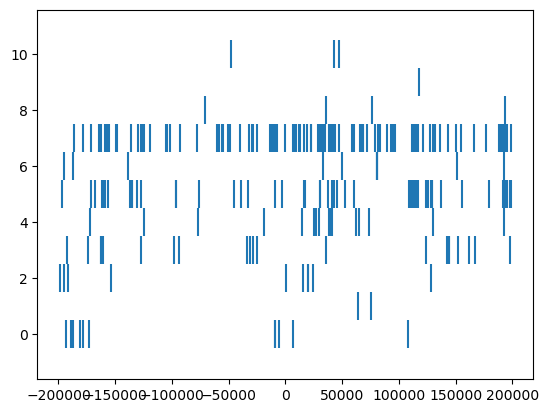

In [72]:
plt.eventplot(example_df["relative_time_to_tone"])

# Calculating average firing rate

In [73]:
merged_spike_trial_df

,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,...,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome,trial_number,trial_chunked_ephys_timestamp,timestamp_bin,relative_time_to_tone
0,89,8060750,89,11,11,13,17.238409,26,0.0,520.0,...,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100,-199445
1,89,8061199,89,11,11,13,17.238409,26,0.0,520.0,...,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100,-198996
2,89,8061583,89,11,11,13,17.238409,26,0.0,520.0,...,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100,-198612
3,89,8061753,89,11,11,13,17.238409,26,0.0,520.0,...,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100,-198442
4,89,8062027,89,11,11,13,17.238409,26,0.0,520.0,...,Subj 2 blocking Subj 1,NaN,287865,"[1.2, 1.1]",1.1,lose,1,"[8060195, 8062195, 8064195, 8066195, 8068195, ...",-100,-198168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109027,146,38957244,146,0,0,0,14.943707,6,0.0,120.0,...,,NaN,1858872,"[1.2, 1.4]",1.4,rewarded,22,"[38619710, 38621710, 38623710, 38625710, 38627...",68,137534
109028,146,38957331,146,0,0,0,14.943707,6,0.0,120.0,...,,NaN,1858872,"[1.2, 1.4]",1.4,rewarded,22,"[38619710, 38621710, 38623710, 38625710, 38627...",68,137621
109029,204,38957511,204,1,0,1,11.366614,6,0.0,120.0,...,,NaN,1858872,"[1.2, 1.4]",1.4,rewarded,22,"[38619710, 38621710, 38623710, 38625710, 38627...",68,137801
109030,44,38957537,44,3,1,29,9.739503,17,0.0,340.0,...,,NaN,1858872,"[1.2, 1.4]",1.4,rewarded,22,"[38619710, 38621710, 38623710, 38625710, 38627...",68,137827


In [74]:
grouped_df = merged_spike_trial_df.groupby(["recording_file", "timestamp_bin", "spike_clusters", "trial_outcome", "fr"]).count()[["spike_times"]].reset_index()
# Rename the aggregated column

In [75]:
grouped_df["total_number_of_trials"] = grouped_df.apply(lambda row: total_number_of_trials_dict[(row["recording_file"], row["trial_outcome"])], axis=1)

In [76]:
grouped_df["spike_times"] = grouped_df["spike_times"] / grouped_df["total_number_of_trials"] / grouped_df["fr"]

In [77]:
grouped_df

,recording_file,timestamp_bin,spike_clusters,trial_outcome,fr,spike_times,total_number_of_trials
0,20230619_115321_standard_comp_to_omission_D3_s...,-100,11,lose,2.805744,0.152748,14
1,20230619_115321_standard_comp_to_omission_D3_s...,-100,28,lose,0.860467,0.083011,14
2,20230619_115321_standard_comp_to_omission_D3_s...,-100,44,lose,13.732511,0.062417,14
3,20230619_115321_standard_comp_to_omission_D3_s...,-100,44,rewarded,13.732511,0.084957,6
4,20230619_115321_standard_comp_to_omission_D3_s...,-100,44,win,13.732511,0.058256,5
...,...,...,...,...,...,...,...
26797,20230620_114347_standard_comp_to_omission_D4_s...,99,258,rewarded,2.844826,0.087879,16
26798,20230620_114347_standard_comp_to_omission_D4_s...,99,258,win,2.844826,0.175758,4
26799,20230620_114347_standard_comp_to_omission_D4_s...,99,259,lose,1.757098,0.162606,7
26800,20230620_114347_standard_comp_to_omission_D4_s...,99,259,omission,1.757098,0.284560,4


In [78]:
grouped_df["spike_times"].mean()

0.15562798274720827

In [79]:
pivot_df = grouped_df.pivot_table(index=['recording_file', 'spike_clusters', 'trial_outcome'], columns='timestamp_bin', values='spike_times', fill_value=0).reset_index().set_index("spike_clusters")

In [80]:
pivot_df

timestamp_bin,recording_file,trial_outcome,-100,-99,-98,-97,-96,-95,-94,-93,...,90,91,92,93,94,95,96,97,98,99
spike_clusters,,,,,,,,,,,,,,,,,,,,,
11,20230619_115321_standard_comp_to_omission_D3_s...,lose,0.152748,0.050916,0.050916,0.101832,0.152748,0.152748,0.025458,0.050916,...,0.229122,0.127290,0.050916,0.152748,0.229122,0.254580,0.152748,0.127290,0.280038,0.127290
11,20230619_115321_standard_comp_to_omission_D3_s...,rewarded,0.000000,0.059402,0.059402,0.059402,0.118804,0.178206,0.000000,0.059402,...,0.000000,0.000000,0.059402,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11,20230619_115321_standard_comp_to_omission_D3_s...,win,0.000000,0.071282,0.071282,0.000000,0.071282,0.071282,0.142565,0.071282,...,0.000000,0.142565,0.000000,0.142565,0.000000,0.000000,0.000000,0.000000,0.000000,0.142565
28,20230619_115321_standard_comp_to_omission_D3_s...,lose,0.083011,0.083011,0.249034,0.166023,0.166023,0.581080,0.166023,0.249034,...,0.000000,0.249034,0.000000,0.083011,0.083011,0.166023,0.249034,0.166023,0.249034,0.083011
28,20230619_115321_standard_comp_to_omission_D3_s...,rewarded,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,20230620_114347_standard_comp_to_omission_D4_s...,win,0.087879,0.087879,0.000000,0.175758,0.087879,0.175758,0.087879,0.087879,...,0.087879,0.087879,0.000000,0.000000,0.175758,0.087879,0.175758,0.175758,0.263637,0.175758
259,20230620_114347_standard_comp_to_omission_D4_s...,lose,0.162606,0.081303,0.162606,0.081303,0.000000,0.162606,0.081303,0.162606,...,0.081303,0.081303,0.243909,0.162606,0.243909,0.162606,0.000000,0.162606,0.081303,0.162606
259,20230620_114347_standard_comp_to_omission_D4_s...,omission,0.000000,0.426840,0.000000,0.000000,0.142280,0.000000,0.000000,0.000000,...,0.284560,0.142280,0.000000,0.000000,0.000000,0.284560,0.000000,0.000000,0.142280,0.284560


In [81]:
from matplotlib.colors import LogNorm, Normalize


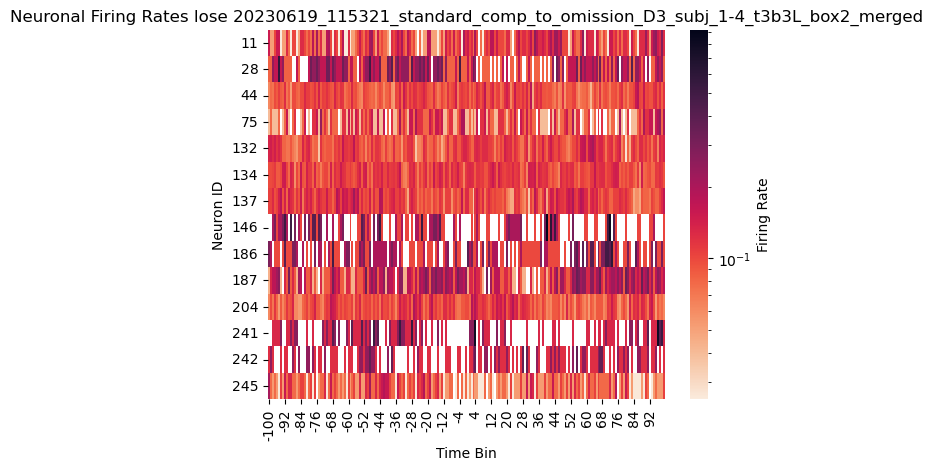

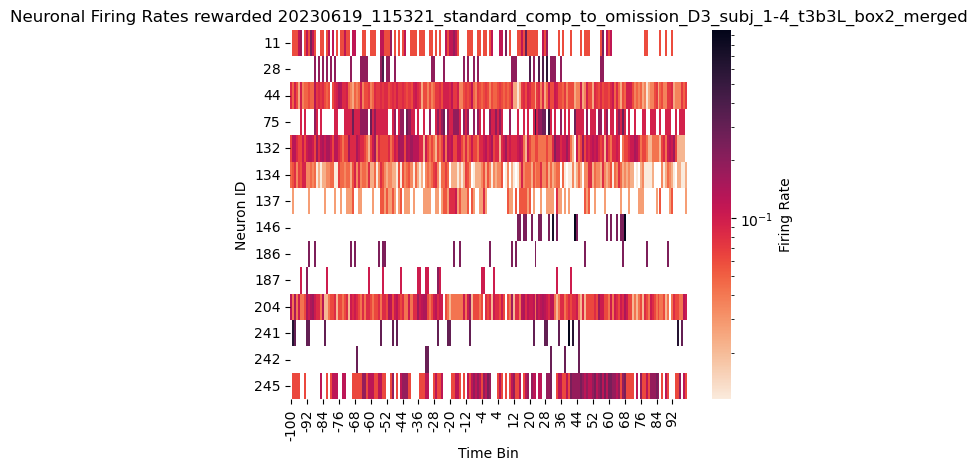

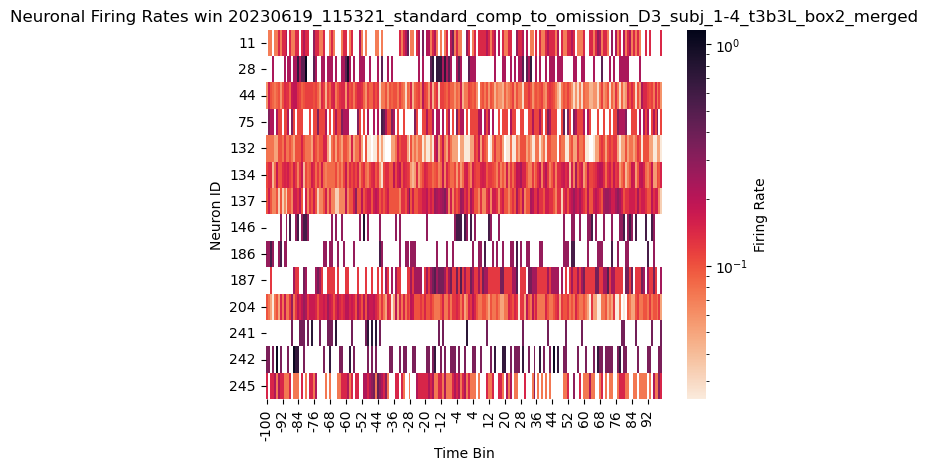

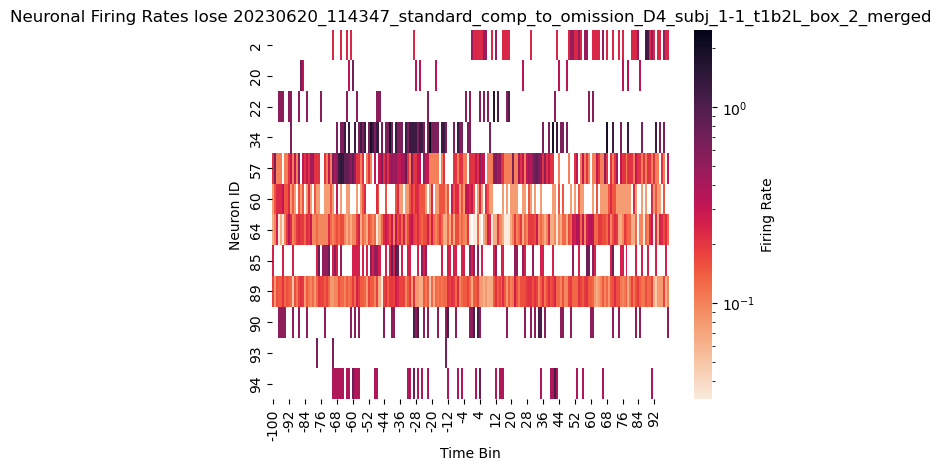

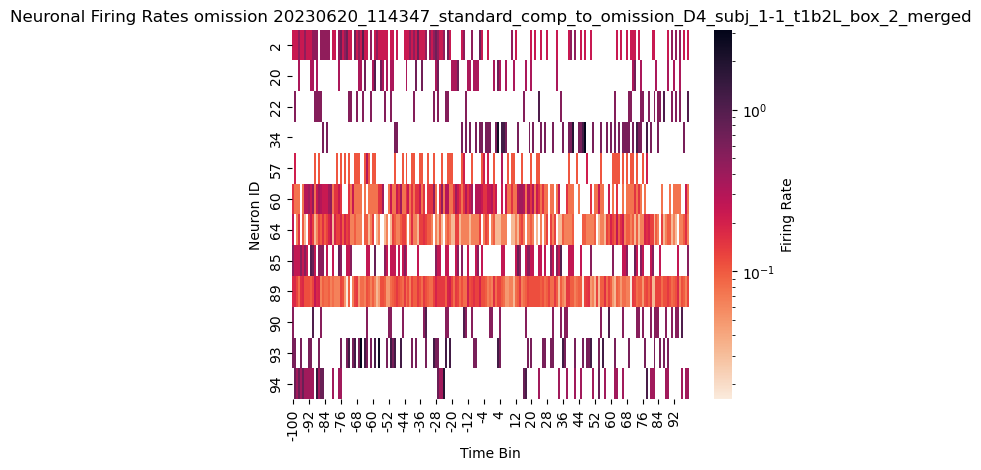

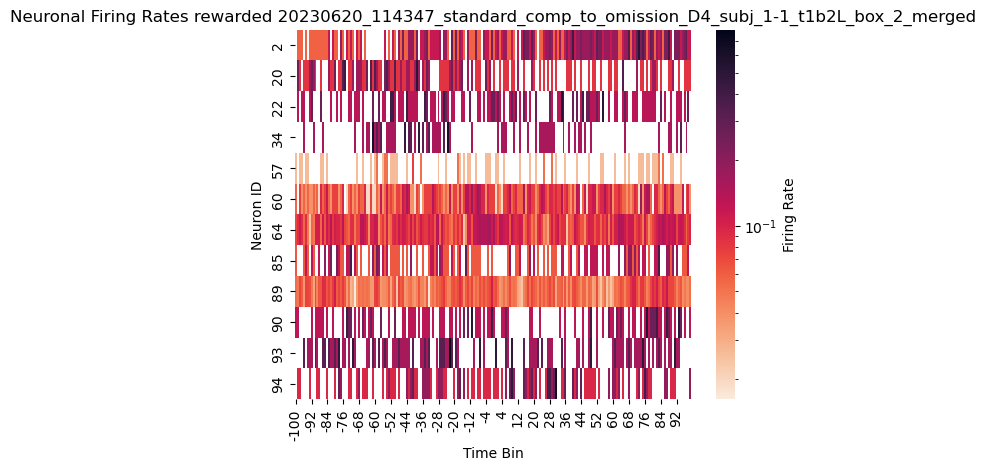

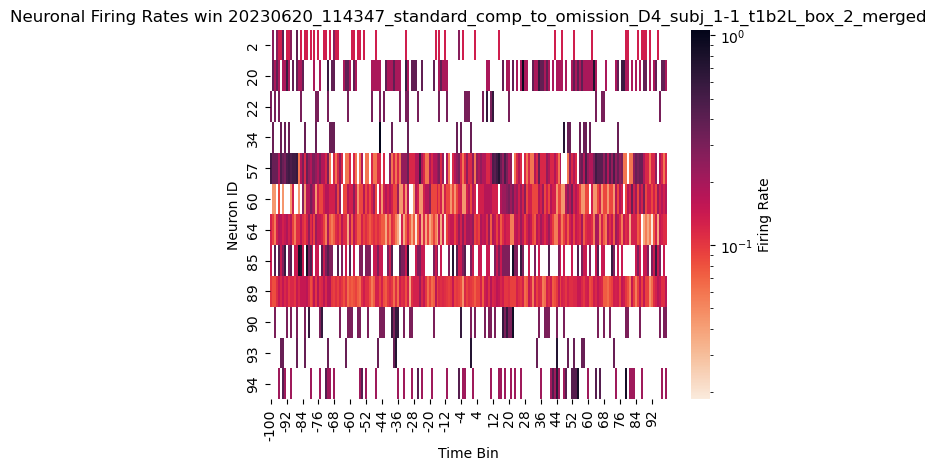

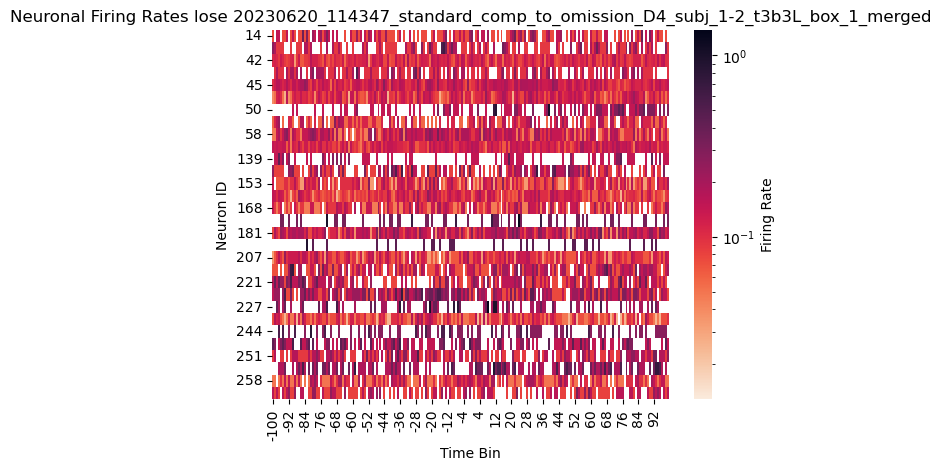

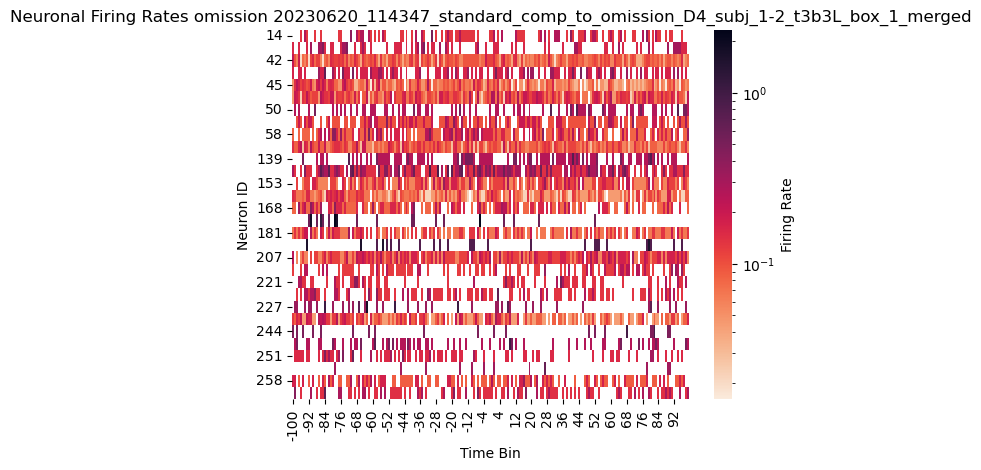

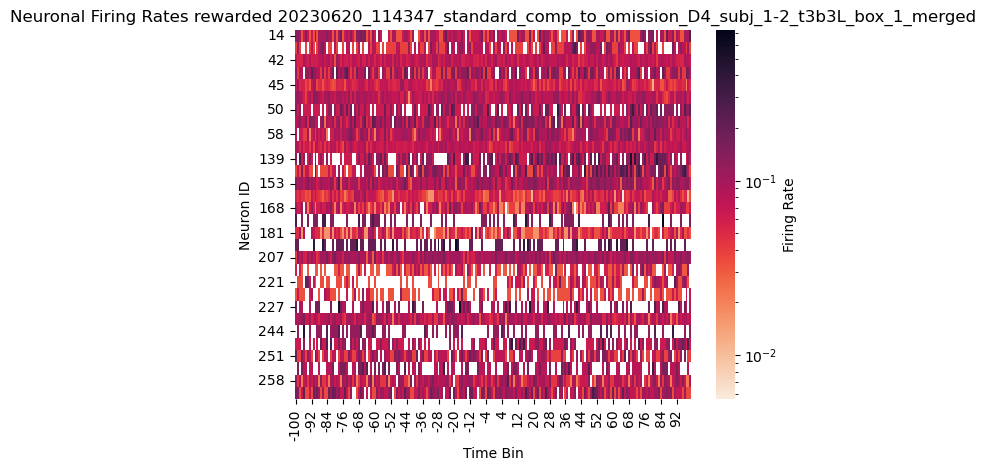

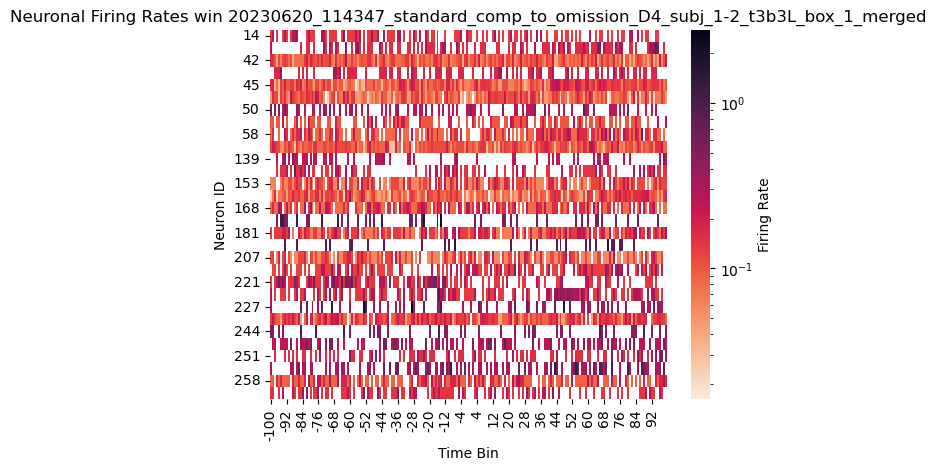

In [82]:
for recording_file in pivot_df["recording_file"].unique():
    recording_df = pivot_df[pivot_df["recording_file"] == recording_file].copy()
    for outcome in recording_df["trial_outcome"].unique():
        outcome_df = recording_df[recording_df["trial_outcome"] == outcome].drop(columns=["recording_file", "trial_outcome"])
        
        sns.heatmap(outcome_df, annot=False, cmap='rocket_r', cbar_kws={'label': 'Firing Rate'}, norm=LogNorm())
        
        # Customizing the plot
        plt.title('Neuronal Firing Rates {} {}'.format(outcome, recording_file))
        plt.xlabel('Time Bin')
        plt.ylabel('Neuron ID')
        
        # Show the plot
        plt.show()


# Plotting PCA

In [83]:
merged_spike_trial_df["unique_neuron"] = "id" + merged_spike_trial_df["spike_clusters"].astype(str) + "_" + merged_spike_trial_df["recording_file"]

merged_spike_trial_df["time_bin_and_outcome"] = merged_spike_trial_df["timestamp_bin"].astype(str) + "_" + merged_spike_trial_df["trial_outcome"]

In [84]:
grouped_df = merged_spike_trial_df.groupby(["time_bin_and_outcome", "unique_neuron", "recording_file", "trial_outcome"]).count()[["spike_times"]].reset_index()
# Rename the aggregated column

In [85]:
grouped_df

,time_bin_and_outcome,unique_neuron,recording_file,trial_outcome,spike_times
0,-100_lose,id11_20230619_115321_standard_comp_to_omission...,20230619_115321_standard_comp_to_omission_D3_s...,lose,6
1,-100_lose,id124_20230620_114347_standard_comp_to_omissio...,20230620_114347_standard_comp_to_omission_D4_s...,lose,9
2,-100_lose,id132_20230619_115321_standard_comp_to_omissio...,20230619_115321_standard_comp_to_omission_D3_s...,lose,15
3,-100_lose,id134_20230619_115321_standard_comp_to_omissio...,20230619_115321_standard_comp_to_omission_D3_s...,lose,20
4,-100_lose,id137_20230619_115321_standard_comp_to_omissio...,20230619_115321_standard_comp_to_omission_D3_s...,lose,9
...,...,...,...,...,...
26797,9_win,id58_20230620_114347_standard_comp_to_omission...,20230620_114347_standard_comp_to_omission_D4_s...,win,2
26798,9_win,id60_20230620_114347_standard_comp_to_omission...,20230620_114347_standard_comp_to_omission_D4_s...,win,4
26799,9_win,id64_20230620_114347_standard_comp_to_omission...,20230620_114347_standard_comp_to_omission_D4_s...,win,6
26800,9_win,id85_20230620_114347_standard_comp_to_omission...,20230620_114347_standard_comp_to_omission_D4_s...,win,1


In [86]:
grouped_df["total_number_of_trials"] = grouped_df.apply(lambda row: total_number_of_trials_dict[(row["recording_file"], row["trial_outcome"])], axis=1)

In [87]:
grouped_df["spike_times"] = grouped_df["spike_times"] / grouped_df["total_number_of_trials"]

In [88]:
grouped_df["spike_times"].mean()

0.5488189625152352

In [89]:
pivot_df = grouped_df.pivot_table(index=['unique_neuron'], columns='time_bin_and_outcome', values='spike_times', fill_value=0).reset_index().set_index("unique_neuron")

In [90]:
pivot_df.head()

time_bin_and_outcome,-100_lose,-100_omission,-100_rewarded,-100_win,-10_lose,-10_omission,-10_rewarded,-10_win,-11_lose,-11_omission,...,98_rewarded,98_win,99_lose,99_omission,99_rewarded,99_win,9_lose,9_omission,9_rewarded,9_win
unique_neuron,,,,,,,,,,,,,,,,,,,,,
id11_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged,0.428571,0.00,0.000000,0.0,0.285714,0.00,0.166667,0.2,0.428571,0.0,...,0.000000,0.00,0.357143,0.0,0.000000,0.40,0.285714,0.00,0.000000,0.40
id124_20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged,1.285714,1.25,0.812500,1.0,1.285714,1.25,0.500000,1.0,1.000000,0.5,...,0.750000,0.75,1.000000,0.5,0.812500,0.75,1.000000,1.25,0.375000,0.25
id132_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged,1.071429,0.00,0.500000,0.6,1.000000,0.00,0.500000,0.6,0.714286,0.0,...,0.166667,0.40,1.071429,0.0,0.000000,0.20,1.000000,0.00,0.666667,1.00
id134_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged,1.428571,0.00,0.666667,1.6,1.714286,0.00,0.500000,1.0,1.928571,0.0,...,0.166667,1.40,1.357143,0.0,0.333333,2.20,1.357143,0.00,0.500000,2.40
id137_20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged,0.642857,0.00,0.000000,0.6,0.642857,0.00,0.000000,2.0,0.642857,0.0,...,0.000000,0.40,1.000000,0.0,0.166667,0.20,0.428571,0.00,0.333333,0.40


In [91]:
# performing preprocessing part
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [92]:
pivot_df.to_numpy()

array([[0.42857143, 0.        , 0.        , ..., 0.        , 0.        ,
        0.4       ],
       [1.28571429, 1.25      , 0.8125    , ..., 1.25      , 0.375     ,
        0.25      ],
       [1.07142857, 0.        , 0.5       , ..., 0.        , 0.66666667,
        1.        ],
       ...,
       [0.        , 0.25      , 0.0625    , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.25      , 0.        , ..., 0.        , 0.1875    ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.3125    ,
        0.        ]])

In [93]:
scaled_firing_rates = sc.fit_transform(pivot_df.to_numpy())


In [94]:
# Applying PCA function on training
# and testing set of X component
from sklearn.decomposition import PCA
 


In [95]:
pca = PCA(n_components = 2)



In [96]:
pca_firing_rates = pca.fit_transform(scaled_firing_rates)


In [97]:
principal_df = pd.DataFrame(data = pca_firing_rates
             , columns = ['principal component 1', 'principal component 2'])

In [98]:
principal_df.head()

,principal component 1,principal component 2
0,-9.723257,4.793946
1,34.028358,-6.795769
2,13.593079,12.001906
3,34.922085,32.804488
4,2.186633,13.383333


In [99]:
pc1_product = pivot_df.reset_index(drop=True).multiply(principal_df["principal component 1"], axis="index")

In [100]:
pc2_product = pivot_df.reset_index(drop=True).multiply(principal_df["principal component 2"], axis="index")

In [101]:
pc_product = pd.concat([pc1_product.mean(), pc2_product.mean()], axis=1).reset_index()

In [102]:
pc_product

,time_bin_and_outcome,0,1
0,-100_lose,10.726156,0.411562
1,-100_omission,10.454358,-1.934419
2,-100_rewarded,6.827765,0.251877
3,-100_win,10.109529,0.848464
4,-10_lose,14.171509,0.310210
...,...,...,...
795,99_win,11.722396,0.378958
796,9_lose,12.011016,1.154015
797,9_omission,8.914793,-1.823297
798,9_rewarded,6.299558,-0.059722


In [103]:
pc_product["bin_time"] = pc_product["time_bin_and_outcome"].apply(lambda x: int(x.split("_")[0]))
pc_product["trial_type"] = pc_product["time_bin_and_outcome"].apply(lambda x: (x.split("_")[1]))

In [104]:
outcome_to_color = {"lose": "orange", "rewarded": "green", "win": "blue", "omission": "red"}

In [105]:
pc_product["color"] = pc_product["trial_type"].map(outcome_to_color)

In [106]:
pc_product

,time_bin_and_outcome,0,1,bin_time,trial_type,color
0,-100_lose,10.726156,0.411562,-100,lose,orange
1,-100_omission,10.454358,-1.934419,-100,omission,red
2,-100_rewarded,6.827765,0.251877,-100,rewarded,green
3,-100_win,10.109529,0.848464,-100,win,blue
4,-10_lose,14.171509,0.310210,-10,lose,orange
...,...,...,...,...,...,...
795,99_win,11.722396,0.378958,99,win,blue
796,9_lose,12.011016,1.154015,9,lose,orange
797,9_omission,8.914793,-1.823297,9,omission,red
798,9_rewarded,6.299558,-0.059722,9,rewarded,green


In [120]:
pc_product["bin_time"] = pc_product["bin_time"].astype(int)

all_outcome_df = []
for outcome in pc_product["trial_type"].unique():
    outcome_df = pc_product[pc_product["trial_type"] == outcome]
    outcome_df = outcome_df.sort_values(["bin_time"])
    outcome_df['0'] = outcome_df[0].rolling(10).mean()    
    outcome_df['1'] = outcome_df[1].rolling(10).mean()
    all_outcome_df.append(outcome_df)

In [127]:
pc_product = pd.concat(all_outcome_df).dropna()

In [128]:
pc_product

,time_bin_and_outcome,0,1,bin_time,trial_type,color,0,1
360,-91_lose,8.828601,0.763104,-91,lose,orange,11.208702,0.657990
356,-90_lose,9.127780,0.544529,-90,lose,orange,11.048864,0.671286
348,-89_lose,11.620154,0.610256,-89,lose,orange,11.228984,0.627491
344,-88_lose,10.550013,1.077705,-88,lose,orange,10.963484,0.710546
340,-87_lose,13.860044,-0.158012,-87,lose,orange,11.137922,0.640939
...,...,...,...,...,...,...,...,...
779,95_win,9.413516,0.064413,95,win,blue,10.167856,1.047250
783,96_win,11.844373,0.219803,96,win,blue,10.367468,1.079156
787,97_win,10.759073,0.478693,97,win,blue,10.512523,1.006513
791,98_win,9.627585,0.695078,98,win,blue,10.246521,0.971533


In [135]:
sigma = 3
divider = 5

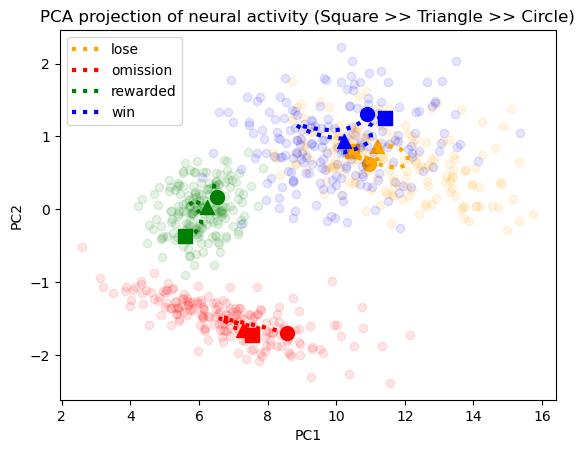

In [136]:
# Create scatter plot
# plt.plot(pc_product[0], pc_product[1], color=pc_product["color"])

for outcome in pc_product["trial_type"].unique():
    
    outcome_df = pc_product[pc_product["trial_type"] == outcome].sort_values("bin_time")
    plt.scatter(outcome_df[0], outcome_df[1], color=outcome_to_color[outcome], alpha=0.1)
    
    smoothed_x = gaussian_filter1d(outcome_df[0][::divider], sigma=sigma)
    
    # smoothed_x = outcome_df[0].rolling(window=10).mean()[::10]
    smoothed_y = gaussian_filter1d(outcome_df[1][::divider], sigma=sigma)
    # smoothed_y = outcome_df[1].rolling(window=10).mean()[::10]

    plt.scatter(smoothed_x[0], smoothed_y[0], color=outcome_to_color[outcome], marker = 'o', s=100)
    plt.scatter(smoothed_x[len(smoothed_x)//2], smoothed_y[len(smoothed_y)//2], color=outcome_to_color[outcome], marker = '^', s=100)
    plt.scatter(smoothed_x[len(smoothed_x)-1], smoothed_y[len(smoothed_y)-1], color=outcome_to_color[outcome], marker = 's', s=100)

    
    # Create smoothed line plot
    plt.plot(smoothed_x, smoothed_y, color=outcome_to_color[outcome], ls=':', label=outcome, linewidth=3)

plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection of neural activity (Square >> Triangle >> Circle)")
plt.savefig("./pca_rce.png")
# Show plot
plt.show()

In [109]:
raise ValueError()

ValueError: 